In [1]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

Load Data

In [2]:
tv = TvDatafeed()

df = tv.get_hist(symbol='SET:SET50', exchange='SET', interval=Interval.in_daily, n_bars=1201)

you are using nologin method, data you access may be limited


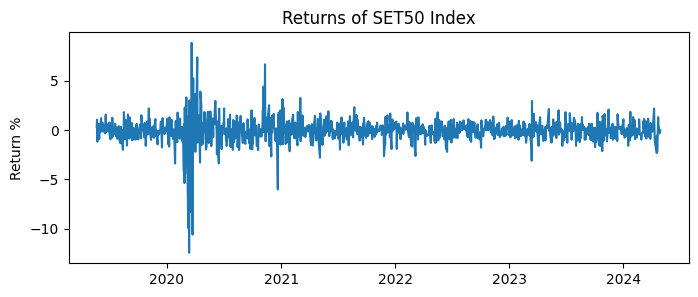

In [3]:
returns = np.log(df['close']).diff().dropna() * 100 #1st difference
plt.figure(figsize=(8,3))
plt.plot(returns)
plt.ylabel("Return %")
plt.title('Returns of SET50 Index');

Train-Test Split

In [4]:
returns_train, returns_test= returns[:-240], returns[-240:]

Methods tried

In [5]:
from arch import arch_model
garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off')
#print(garch_model_fit.summary)

In [6]:
arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off')
#print(arch_model_fit.summary)

In [7]:
gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off')
#print(gjr_garch_model_fit.summary)

In [8]:
harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off')
#print(harch_model_fit.summary)

Real Volatility

In [10]:
real_vol = []
for i in range(len(returns)):
    vol = returns[:i].std()
    real_vol.append(vol)
test_vol = real_vol[-240:]

Forecast

In [11]:
garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)

In [12]:
garch = garch_forecast.variance.values[-1,:].flatten()
arch = arch_forecast.variance.values[-1,:].flatten()
gjr = gjr_garch_forecast.variance.values[-1,:].flatten()
harch = harch_forecast.variance.values[-1,:].flatten()

In [14]:
df_test = returns_test.to_frame(name='return')
df_test['garch']= np.sqrt(garch)
df_test['arch']= np.sqrt(arch)
df_test['gjr']= np.sqrt(gjr)
df_test['harch']= np.sqrt(harch)
df_test['Vol'] = np.array(test_vol)
df_test

,return,garch,arch,gjr,harch,Vol
datetime,,,,,,
2023-05-09 09:00:00,-0.049499,1.016220,1.793036,0.927132,1.793026,1.286797
2023-05-10 09:00:00,0.260927,1.019651,1.606310,0.931565,1.606299,1.286127
2023-05-11 09:00:00,-0.117754,1.022998,1.503211,0.935896,1.503201,1.285488
2023-05-12 09:00:00,-0.300275,1.026264,1.448353,0.940128,1.448344,1.284824
2023-05-15 09:00:00,-1.258249,1.029452,1.419841,0.944264,1.419832,1.284190
...,...,...,...,...,...,...
2024-04-23 09:00:00,0.547040,1.167382,1.390142,1.140907,1.390136,1.204283
2024-04-24 09:00:00,0.304748,1.167402,1.390142,1.140953,1.390136,1.203891
2024-04-25 09:00:00,0.216599,1.167422,1.390142,1.140998,1.390136,1.203424


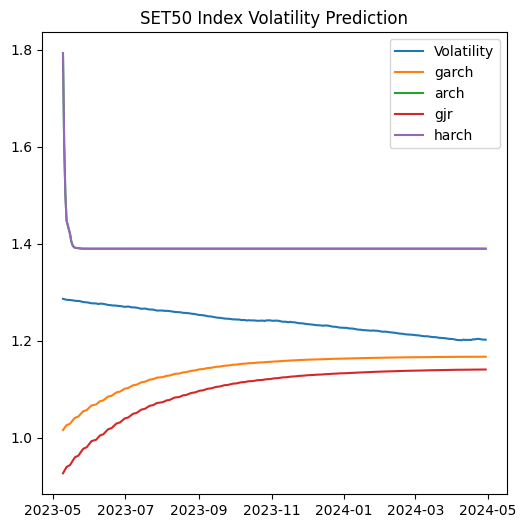

In [15]:
plt.figure(figsize=(6,6))
plt.plot(df_test['Vol'],label = 'Volatility')
plt.plot(df_test['garch'], label = 'garch') 
plt.plot(df_test['arch'], label = 'arch')
plt.plot(df_test['gjr'], label = 'gjr')
plt.plot(df_test['harch'], label = 'harch') 
plt.legend()
plt.title('SET50 Index Volatility Prediction')
plt.show()

Estimation Result

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

garch_mse = mean_squared_error(df_test['Vol'],df_test['garch'])
arch_mse = mean_squared_error(df_test['Vol'],df_test['arch'])
gjr_garch_mse = mean_squared_error(df_test['Vol'],df_test['gjr'])
harch_mse = mean_squared_error(df_test['Vol'],df_test['harch'])
mse = [garch_mse,arch_mse,gjr_garch_mse,harch_mse]

garch_rmse = np.sqrt(garch_mse)
arch_rmse = np.sqrt(arch_mse)
gjr_garch_rmse = np.sqrt(gjr_garch_mse)
harch_rmse = np.sqrt(harch_mse)
rmse = [garch_rmse,arch_rmse,gjr_garch_rmse,harch_rmse]

garch_mae = mean_absolute_error(df_test['Vol'],df_test['garch'])
arch_mae = mean_absolute_error(df_test['Vol'],df_test['arch'])
gjr_garch_mae = mean_absolute_error(df_test['Vol'],df_test['gjr'])
harch_mae = mean_absolute_error(df_test['Vol'],df_test['harch'])
mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]

garch_mape = mean_absolute_percentage_error(df_test['Vol'],df_test['garch'])
arch_mape = mean_absolute_percentage_error(df_test['Vol'],df_test['arch'])
gjr_garch_mape = mean_absolute_percentage_error(df_test['Vol'],df_test['gjr'])
harch_mape = mean_absolute_percentage_error(df_test['Vol'],df_test['harch'])
mape = [garch_mape,arch_mape,gjr_garch_mape,harch_mape]

In [23]:
model = ['GARCH','ARCH','GJR','HARCH']
conclu = pd.DataFrame(model, columns=['Model'])
conclu['MSE'] = mse
conclu['RMSE'] = rmse
conclu['MAE'] = mae
conclu['MAPE'] = mape
conclu

,Model,MSE,RMSE,MAE,MAPE
0,GARCH,0.013884,0.117830,0.101673,0.081064
1,ARCH,0.024509,0.156553,0.152639,0.123327
2,GJR,0.026432,0.162580,0.143654,0.114661
3,HARCH,0.024507,0.156547,0.152633,0.123322


Fit entire dataset with the best model

In [24]:
forecast_model_fit = arch_model(returns,vol="GARCH",p=1,q=1).fit(disp='off')
print(forecast_model_fit.summary)

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1607.99
Distribution:                  Normal   AIC:                           3223.99
Method:            Maximum Likelihood   BIC:                           3244.35
                                        No. Observations:                 1200
Date:                Mon, Apr 29 2024   Df Residuals:                     1199
Time:                        11:05:28   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            

In [25]:
forecaste = forecast_model_fit.forecast(horizon=120,method='analytic',reindex=True)
y = forecaste.variance.values[-1,:].flatten()
df_y = pd.DataFrame(y)
df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(252)

In [26]:
df_y['forecast']

0      15.471817
1      15.502743
2      15.532814
3      15.562055
4      15.590490
         ...    
115    16.575068
116    16.576507
117    16.577909
118    16.579276
119    16.580607
Name: forecast, Length: 120, dtype: float64